In [166]:
import numpy as np
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import bicgstab, gmres
from scipy.linalg import solve, lu, solve_triangular
import time
from matplotlib.animation import FuncAnimation, PillowWriter

In [167]:
## Homework 4 

## Part a)
# Get matrix A
n = 64
N = n * n
L = 10
x = np.linspace(-L, L, n+1)
y = np.linspace(-L, L, n+1)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
x[:-1]; y[:-1]


main_dia = np.ones(N) 
left_dia = np.ones(N) 
n_1_dia = np.zeros(N) 


for j in range(1, n+1):
    left_dia[n*j-1] = 0 
    n_1_dia[n*j-1] = 1 


right_dia = np.zeros_like(left_dia) 
right_dia[1:N] = left_dia[0:N-1]
right_dia[0] = left_dia[N-1]


minus_n_1_dia = np.zeros_like(n_1_dia)
minus_n_1_dia[1:N] = n_1_dia[0:N-1]
minus_n_1_dia[0] = n_1_dia[N-1]

    
diagonals = [main_dia, main_dia, minus_n_1_dia, 
             left_dia, -4 * main_dia, right_dia, 
             n_1_dia, main_dia, main_dia]

offsets = [-(N-n), -n, -n+1, -1, 0, 1, n-1, n, (N-n)]
    
A = spdiags(diagonals, offsets, N, N).toarray()

A = A / (delta_x * delta_x)


### get new A for Homework 5 - part b

A_b1 = spdiags(diagonals, offsets, N, N).toarray()
A_b1[0,0] = 2
A_b = A_b1 / (delta_x * delta_x)
#print(A_b)

#print(A)

#plt.figure(figsize=(10, 10))
#plt.title("Matrix A1", fontsize=18)
#plt.imshow(A, cmap='gray', interpolation='none')
#plt.colorbar()

#A1 = A





# Get matrix B
main_dia_b = np.ones(N)
left_dia_b = -1 * np.ones(N)
right_dia_b = np.ones(N)
diagonals_b = [main_dia_b, left_dia_b, right_dia_b, -1*main_dia_b]
offsets_b = [-(N-n), -n, n, (N-n)]

B = spdiags(diagonals_b, offsets_b, N, N).toarray()

B = B / (2 * delta_x)
#print(B)

#plt.figure(figsize=(10, 10))
#plt.title("Matrix A2", fontsize=18)
#plt.imshow(B, cmap='gray', interpolation='none')
#plt.colorbar()

#A2 = B

# Get matrix C

right_dia_c = np.ones(N)
left_dia_c = np.ones(N)
n_1_dia_c = np.zeros(N) 

for j in range(1, n+1):
    left_dia_c[n*j-1] = 0 # overwrite every m^th value with zero 
    n_1_dia_c[n*j-1] = 1 # overwirte every m^th value with one


minus_n_1_dia_c = np.zeros_like(n_1_dia_c)
minus_n_1_dia_c[1:N] = n_1_dia_c[0:N-1]
minus_n_1_dia_c[0] = n_1_dia_c[N-1]

right_dia_c = np.zeros_like(left_dia_c) 
right_dia_c[1:N] = left_dia_c[0:N-1]
right_dia_c[0] = left_dia_c[N-1]

diagonals_c = [minus_n_1_dia_c, -1 * left_dia_c, right_dia_c, -1 * n_1_dia_c]
offsets_c = [-n+1, -1, 1, n-1]


C = spdiags(diagonals_c, offsets_c, N, N).toarray()

C = C / (2 * delta_y)
#print(C)

#plt.figure(figsize=(10, 10))
#plt.title("Matrix A3", fontsize=18)
#plt.imshow(C, cmap='gray', interpolation='none')
#plt.colorbar()

#A3 = C

Solve Part a) Using FFT

In [168]:
## Homework 5, Part a) Using FFT
nu = 0.001
tspan = np.linspace(0, 4, 9)  #np.linspace(0, 4, 9) 
print(tspan)

Lx, Ly = 20, 20
nx, ny = 64, 64
N2 = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1); x2 = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1); y2 = y2[:ny]
X, Y = np.meshgrid(x2, y2)

w = 1 * np.exp(-X ** 2 - (Y ** 2)/20) 
w0 = w.reshape(N2)

# Define spectral k values
kx = ((2 * np.pi) / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = ((2 * np.pi) / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
kx[0] = 1e-6; ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX ** 2 + KY ** 2




def fft_rhs(t, w2): 
    w = w2.reshape((nx, ny)) 
    wt = fft2(w)
    psi_t = - wt / K
    psi = np.real(ifft2(psi_t)).reshape(N2)
    rhs = nu * np.dot(A_b, w2) + (np.dot(B, w2)) * (np.dot(C, psi)) - (np.dot(B, psi)) * (np.dot(C, w2))
    return rhs 



wsol2 = solve_ivp(fft_rhs, [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
wsol = wsol2.y
print(wsol)
#wsol = wsol.reshape((nx, ny))

A1 = wsol



[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
[[2.50656748e-46 3.59343426e-45 1.89141923e-44 ... 1.90792904e-42
  4.82195572e-42 1.14719429e-41]
 [1.17762859e-43 6.53684735e-43 2.62060754e-42 ... 1.58866557e-40
  3.55916152e-40 7.45533788e-40]
 [4.55107657e-41 1.93087628e-40 6.43663355e-40 ... 2.48966551e-38
  5.07459635e-38 9.69185374e-38]
 ...
 [1.96785570e-38 1.23636238e-37 5.46906656e-37 ... 4.35977114e-35
  1.02335874e-34 2.22858322e-34]
 [6.19028421e-41 5.34124949e-40 2.93882031e-39 ... 3.68664229e-37
  9.45501433e-37 2.23512843e-36]
 [1.60178709e-43 1.99879166e-42 1.41268009e-41 ... 2.80496038e-39
  7.96285822e-39 2.07493092e-38]]


Plot part a) FFT

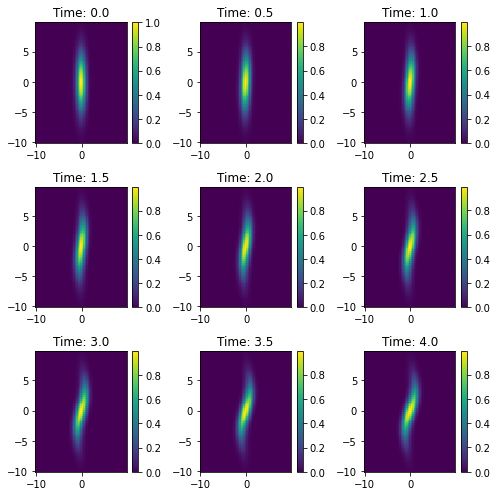

In [169]:
## Plot part a) FFT

# Plot subplots by time
plt.figure(figsize=(7,7))
for j, t in enumerate(tspan):
    w_plot = wsol[:, j].reshape((nx, ny))
    plt.subplot(3, 3, j + 1)  
    plt.pcolor(x2, y2, w_plot, shading = 'auto')  
    plt.title(f'Time: {t}')
    plt.colorbar()
plt.tight_layout()
plt.show()

# Create an animation
fig, ax = plt.subplots(figsize=(10,8), dpi=300)  
im = ax.pcolor(x2, y2, wsol[:,0].reshape((nx, ny)), shading = 'auto', cmap = 'viridis', vmin=0, vmax=1)  
colorbar = fig.colorbar(im, ax=ax)
ax.tick_params(labelsize=20, length=10)
colorbar.ax.tick_params(labelsize=20, length=10)

def update(j):
    w_plot1 = wsol[:, j].reshape((nx, ny))
    im.set_array(w_plot1.ravel())
    ax.set_title('Solution of using FFT', fontsize=27, weight='ultralight')
    return [im]

anim = FuncAnimation(fig=fig, func=update, frames=len(tspan), interval=200, blit=True)
anim.save('fft_animation.gif', writer=PillowWriter(fps=5), dpi=300)
plt.close()

Solve Part b), Using Direct Method: A\b

In [170]:
## Part b), Using Direct Method: A\b
def solve_direct(t, w2):
    psi = solve(A_b, w2)
    rhs = nu * np.dot(A_b, w2) + (np.dot(B, w2)) * (np.dot(C, psi)) - (np.dot(B, psi)) * (np.dot(C, w2))
    return rhs

w_solAb2 = solve_ivp(solve_direct, [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
w_solAb = w_solAb2.y
print(w_solAb)

A2 = w_solAb


[[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ... -5.75086257e-26
  -6.68013806e-25  3.02201851e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]


Plot part b) Direct Method

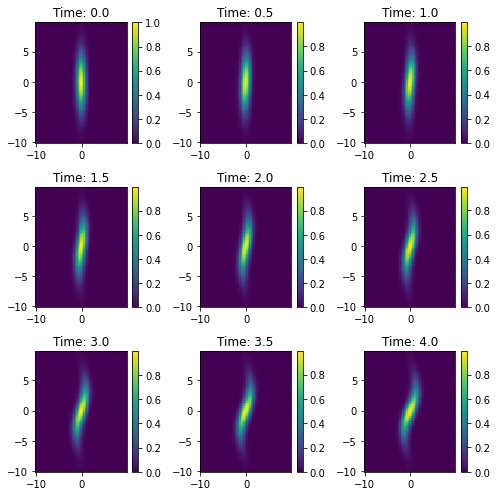

In [171]:
## Plot part b) Direct Method

# Plot subplots by time
plt.figure(figsize=(7,7))
for j, t in enumerate(tspan):
    w_plot2 = w_solAb[:, j].reshape((nx, ny))
    plt.subplot(3, 3, j + 1)  
    plt.pcolor(x2, y2, w_plot2, shading = 'auto')  
    plt.title(f'Time: {t}')
    plt.colorbar()
plt.tight_layout()
plt.show()

# Create an animation
fig, ax = plt.subplots(figsize=(10,8), dpi=300)  
im = ax.pcolor(x2, y2, w_solAb[:,0].reshape((nx, ny)), shading = 'auto', cmap = 'viridis', vmin=0, vmax=1)  
colorbar = fig.colorbar(im, ax=ax)
ax.tick_params(labelsize=20, length=10)
colorbar.ax.tick_params(labelsize=20, length=10)

def update(j):
    w_plot1 = w_solAb[:, j].reshape((nx, ny))
    im.set_array(w_plot1.ravel())
    ax.set_title('Solution of using Direct Solving', fontsize=24, weight='ultralight')
    return [im]

anim = FuncAnimation(fig=fig, func=update, frames=len(tspan), interval=200, blit=True)
anim.save('directsolving_animation.gif', writer=PillowWriter(fps=5), dpi=300)
plt.close()

Solve Part b) Using LU Decomposition

In [172]:
## Part b) Using LU Decomposition

P, L, U = lu(A_b)

def LU_rhs(t, w2):
    Pb = np.dot(P, w2)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    rhs = nu * np.dot(A_b, w2) + (np.dot(B, w2)) * (np.dot(C, psi)) - (np.dot(B, psi)) * (np.dot(C, w2))
    return rhs 

w_solLU2 = solve_ivp(LU_rhs, [tspan[0], 4], w0, t_eval=tspan, method='RK45')
w_solLU = w_solLU2.y
print(w_solLU)
print(tspan[-1])
A3 = w_solLU

[[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ... -5.75086257e-26
  -6.68013806e-25  3.02201851e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]
4.0


Plot part b) LU Decomposition

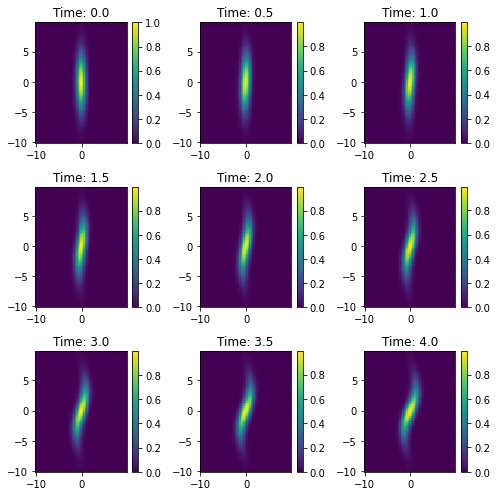

In [173]:
## Plot part b) LU Decomposition

# Plot subplots by time
plt.figure(figsize=(7,7))
for j, t in enumerate(tspan):
    w_plot3 = w_solLU[:, j].reshape((nx, ny))
    plt.subplot(3, 3, j + 1)  
    plt.pcolor(x2, y2, w_plot3, shading = 'auto')  
    plt.title(f'Time: {t}')
    plt.colorbar()
plt.tight_layout()
plt.show()

# Create an animation
fig, ax = plt.subplots(figsize=(10,8), dpi=300)  
im = ax.pcolor(x2, y2, w_solLU[:,0].reshape((nx, ny)), shading = 'auto', cmap = 'viridis', vmin=0, vmax=1)  
colorbar = fig.colorbar(im, ax=ax)
ax.tick_params(labelsize=20, length=10)
colorbar.ax.tick_params(labelsize=20, length=10)

def update(j):
    w_plot1 = w_solLU[:, j].reshape((nx, ny))
    im.set_array(w_plot1.ravel())
    ax.set_title('Solution of using LU Decomposition', fontsize=24, weight='ultralight')
    return [im]

anim = FuncAnimation(fig=fig, func=update, frames=len(tspan), interval=200, blit=True)
anim.save('lu_animation.gif', writer=PillowWriter(fps=5), dpi=300)
plt.close()

# Part c)

Elapsed time in using FFT: 0.58 seconds


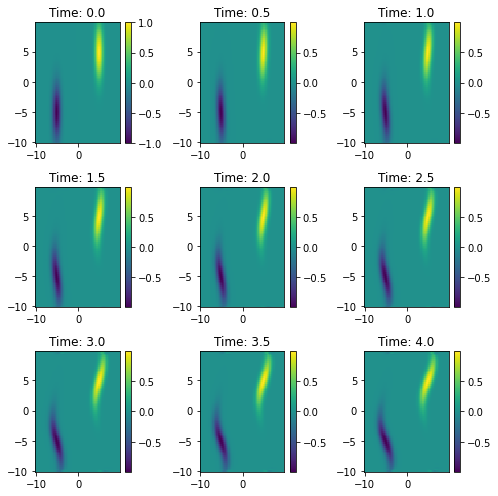

Elapsed time in using FFT: 0.63 seconds


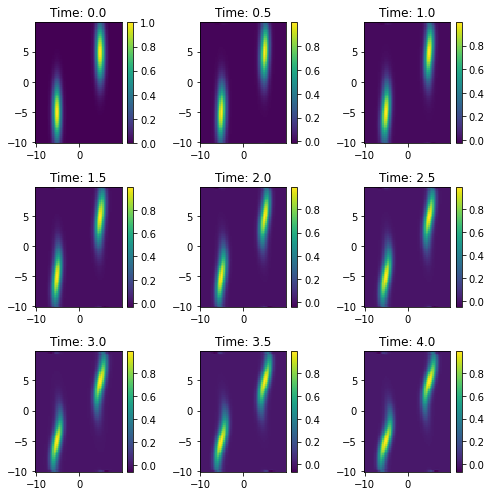

Elapsed time in using FFT: 1.30 seconds


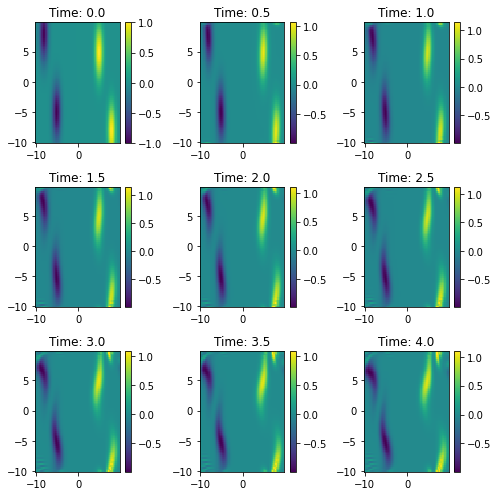

Elapsed time in using FFT: 0.47 seconds


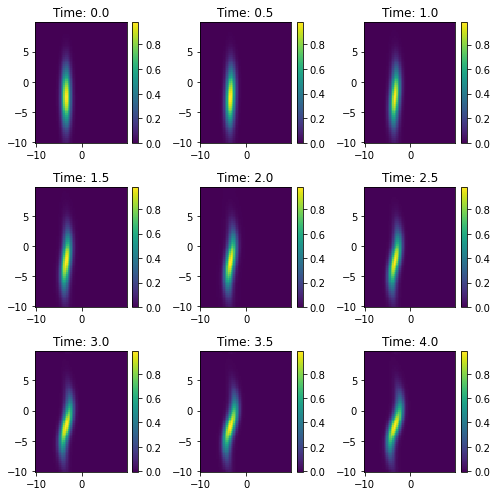

In [174]:
## Part c)
# My favorite and fastest solver is using the FFT

def change_initial(save_file_name, omega_equ):
    # Setting 
    nu = 0.001
    tspan = np.linspace(0, 4, 9)  
    #print(tspan)

    Lx, Ly = 20, 20
    nx, ny = 64, 64
    N2 = nx * ny

    x2 = np.linspace(-Lx/2, Lx/2, nx + 1); x2 = x2[:nx]
    y2 = np.linspace(-Ly/2, Ly/2, ny + 1); y2 = y2[:ny]
    X, Y = np.meshgrid(x2, y2)

    w = omega_equ
    w0 = w.reshape(N2)

    # Define spectral k values
    kx = ((2 * np.pi) / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
    ky = ((2 * np.pi) / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
    kx[0] = 1e-6; ky[0] = 1e-6
    KX, KY = np.meshgrid(kx, ky)
    K = KX ** 2 + KY ** 2


    start_time = time.time() 
    # Using FFT
    def fft_rhs(t, w2): 
        w = w2.reshape((nx, ny)) 
        wt = fft2(w)
        psi_t = - wt / K
        psi = np.real(ifft2(psi_t)).reshape(N2)
        rhs = nu * np.dot(A_b, w2) + (np.dot(B, w2)) * (np.dot(C, psi)) - (np.dot(B, psi)) * (np.dot(C, w2))
        return rhs 

    wsol2 = solve_ivp(fft_rhs, [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
    wsol = wsol2.y

    # A1 = wsol ; print(A1)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time in using FFT: {elapsed_time:.2f} seconds")


    # Plot subplots by time
    plt.figure(figsize=(7,7))
    for j, t in enumerate(tspan):
        w_plot = wsol[:, j].reshape((nx, ny))
        plt.subplot(3, 3, j + 1)  
        plt.pcolor(x2, y2, w_plot, shading = 'auto')  
        plt.title(f'Time: {t}')
        plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Create an animation
    fig, ax = plt.subplots(figsize=(10,8), dpi=300)  
    im = ax.pcolor(x2, y2, wsol[:,0].reshape((nx, ny)), shading = 'auto', cmap = 'turbo') #turbo, viridis, vmin=0, vmax=1 
    colorbar = fig.colorbar(im, ax=ax)
    ax.tick_params(labelsize=20, length=10)
    colorbar.ax.tick_params(labelsize=20, length=10)

    def update(j):
        w_plot1 = wsol[:, j].reshape((nx, ny))
        im.set_array(w_plot1.ravel())
        ax.set_title('Solution of using FFT', fontsize=27)
        return [im]

    anim = FuncAnimation(fig=fig, func=update, frames=len(tspan), interval=200, blit=True)
    anim.save(save_file_name, writer=PillowWriter(fps=3), dpi=300)
    plt.close()

# Two oppositely “charged” Gaussian vorticies next to each other, i.e. one with positive amplitude, the other with negative amplitude.
change_initial('fft_animation_part(c_1).gif', 1 * np.exp(-(X-5) ** 2 - ((Y-5) ** 2)/20) - 1 * np.exp(-(X+5) ** 2 - ((Y+5) ** 2)/20))
    
# Two same “charged” Gaussian vorticies next to each other.
change_initial('fft_animation_part(c_2).gif', 1 * np.exp(-(X-5) ** 2 - ((Y-5) ** 2)/20) + 1 * np.exp(-(X+5) ** 2 - ((Y+5) ** 2)/20))
    
# Two pairs of oppositely “charged” vorticies which can be made to collide with each other.
change_initial('fft_animation_part(c_3).gif', 1 * np.exp(-(X-5) ** 2 - ((Y-5) ** 2)/20) - 1 * np.exp(-(X+5) ** 2 - ((Y+5) ** 2)/20) 
                                            - 1 * np.exp(-(X+8) ** 2 - ((Y-8) ** 2)/20) + 1 * np.exp(-(X-8) ** 2 - ((Y+8) ** 2)/20))


# A random assortment (in position, strength, charge, ellipticity, etc.) of vorticies on the periodic domain. Try 10-15 vorticies and watch what happens.
# Random assortment of vortices
np.random.seed(42)  # For reproducibility
num_vortices = 15
w4 = np.zeros_like(X)

for _ in range(num_vortices):
    x0 = np.random.uniform(-4, 4)             # Random x position
    y0 = np.random.uniform(-4, 4)             # Random y position
    amplitude = np.random.uniform(-3, 3)      # Random strength/charge (-3 to 3)
    ellipticity = np.random.uniform(0.3, 2)   # Random ellipticity (0.3 to 2)
    w = 1 * np.exp(-(X-x0) ** 2 - ((Y-y0) ** 2)/20) 

change_initial('fft_animation_part(c_4).gif', w)

# Part d)
I tried graphing cool plots below.

In [179]:
## Part d)



## Part a)
# Get matrix A
n = 70
N = n * n
L = 10
x = np.linspace(-L, L, n+1)
y = np.linspace(-L, L, n+1)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
x[:-1]; y[:-1]


main_dia = np.ones(N) 
left_dia = np.ones(N) 
n_1_dia = np.zeros(N) 


for j in range(1, n+1):
    left_dia[n*j-1] = 0 
    n_1_dia[n*j-1] = 1 


right_dia = np.zeros_like(left_dia) 
right_dia[1:N] = left_dia[0:N-1]
right_dia[0] = left_dia[N-1]


minus_n_1_dia = np.zeros_like(n_1_dia)
minus_n_1_dia[1:N] = n_1_dia[0:N-1]
minus_n_1_dia[0] = n_1_dia[N-1]

    
diagonals = [main_dia, main_dia, minus_n_1_dia, 
             left_dia, -4 * main_dia, right_dia, 
             n_1_dia, main_dia, main_dia]

offsets = [-(N-n), -n, -n+1, -1, 0, 1, n-1, n, (N-n)]
    
A = spdiags(diagonals, offsets, N, N).toarray()

A = A / (delta_x * delta_x)


### get new A for Homework 5 - part b

A_b1 = spdiags(diagonals, offsets, N, N).toarray()
A_b1[0,0] = 2
A_b = A_b1 / (delta_x * delta_x)

# Get matrix B
main_dia_b = np.ones(N)
left_dia_b = -1 * np.ones(N)
right_dia_b = np.ones(N)
diagonals_b = [main_dia_b, left_dia_b, right_dia_b, -1*main_dia_b]
offsets_b = [-(N-n), -n, n, (N-n)]

B = spdiags(diagonals_b, offsets_b, N, N).toarray()

B = B / (2 * delta_x)

# Get matrix C
right_dia_c = np.ones(N)
left_dia_c = np.ones(N)
n_1_dia_c = np.zeros(N) 

for j in range(1, n+1):
    left_dia_c[n*j-1] = 0 # overwrite every m^th value with zero 
    n_1_dia_c[n*j-1] = 1 # overwirte every m^th value with one


minus_n_1_dia_c = np.zeros_like(n_1_dia_c)
minus_n_1_dia_c[1:N] = n_1_dia_c[0:N-1]
minus_n_1_dia_c[0] = n_1_dia_c[N-1]

right_dia_c = np.zeros_like(left_dia_c) 
right_dia_c[1:N] = left_dia_c[0:N-1]
right_dia_c[0] = left_dia_c[N-1]

diagonals_c = [minus_n_1_dia_c, -1 * left_dia_c, right_dia_c, -1 * n_1_dia_c]
offsets_c = [-n+1, -1, 1, n-1]


C = spdiags(diagonals_c, offsets_c, N, N).toarray()

C = C / (2 * delta_y)



#### HOMEWORK 5 FROM HERE ####



# Part a)
nu = 0.01
tspan = np.linspace(0, 14, 29)  #np.linspace(0, 4, 9) 

Lx, Ly = 30,30
nx, ny = 70, 70
N2 = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1); x2 = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1); y2 = y2[:ny]
X, Y = np.meshgrid(x2, y2)

w = 5 * np.exp(-X ** 2 - (Y ** 2)/20) 
w0 = w.reshape(N2)

# Define spectral k values
kx = ((2 * np.pi) / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = ((2 * np.pi) / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
kx[0] = 1e-6; ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX ** 2 + KY ** 2

def fft_rhs(t, w2): 
    w = w2.reshape((nx, ny)) 
    wt = fft2(w)
    psi_t = - wt / K
    psi = np.real(ifft2(psi_t)).reshape(N2)
    rhs = nu * np.dot(A_b, w2) + (np.dot(B, w2)) * (np.dot(C, psi)) - (np.dot(B, psi)) * (np.dot(C, w2))
    return rhs 

wsol2 = solve_ivp(fft_rhs, [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
wsol = wsol2.y

from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(10,8), dpi=300)  
im = ax.pcolor(x2, y2, wsol[:,0].reshape((nx, ny)), shading = 'auto', cmap = 'turbo', vmin=0, vmax=1)  
colorbar = fig.colorbar(im, ax=ax)
ax.tick_params(labelsize=20, length=10)
colorbar.ax.tick_params(labelsize=20, length=10)

def update(j):
    w_plot1 = wsol[:, j].reshape((nx, ny))
    im.set_array(w_plot1.ravel())
    ax.set_title('Solution of using FFT', fontsize=27)
    return [im]

anim = FuncAnimation(fig=fig, func=update, frames=len(tspan), interval=200, blit=True)
anim.save('fft_animation_part(d_1).gif', writer=PillowWriter(fps=7), dpi=300)
plt.close()

In [176]:
## Trying cool graphs

## Part a)
# Get matrix A
n = 100
N = n * n
L = 10
x = np.linspace(-L, L, n+1)
y = np.linspace(-L, L, n+1)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
x[:-1]; y[:-1]


main_dia = np.ones(N) 
left_dia = np.ones(N) 
n_1_dia = np.zeros(N) 


for j in range(1, n+1):
    left_dia[n*j-1] = 0 
    n_1_dia[n*j-1] = 1 


right_dia = np.zeros_like(left_dia) 
right_dia[1:N] = left_dia[0:N-1]
right_dia[0] = left_dia[N-1]


minus_n_1_dia = np.zeros_like(n_1_dia)
minus_n_1_dia[1:N] = n_1_dia[0:N-1]
minus_n_1_dia[0] = n_1_dia[N-1]

    
diagonals = [main_dia, main_dia, minus_n_1_dia, 
             left_dia, -4 * main_dia, right_dia, 
             n_1_dia, main_dia, main_dia]

offsets = [-(N-n), -n, -n+1, -1, 0, 1, n-1, n, (N-n)]
    
A = spdiags(diagonals, offsets, N, N).toarray()

A = A / (delta_x * delta_x)


### get new A for Homework 5 - part b

A_b1 = spdiags(diagonals, offsets, N, N).toarray()
A_b1[0,0] = 2
A_b = A_b1 / (delta_x * delta_x)

# Get matrix B
main_dia_b = np.ones(N)
left_dia_b = -1 * np.ones(N)
right_dia_b = np.ones(N)
diagonals_b = [main_dia_b, left_dia_b, right_dia_b, -1*main_dia_b]
offsets_b = [-(N-n), -n, n, (N-n)]

B = spdiags(diagonals_b, offsets_b, N, N).toarray()

B = B / (2 * delta_x)

# Get matrix C
right_dia_c = np.ones(N)
left_dia_c = np.ones(N)
n_1_dia_c = np.zeros(N) 

for j in range(1, n+1):
    left_dia_c[n*j-1] = 0 # overwrite every m^th value with zero 
    n_1_dia_c[n*j-1] = 1 # overwirte every m^th value with one


minus_n_1_dia_c = np.zeros_like(n_1_dia_c)
minus_n_1_dia_c[1:N] = n_1_dia_c[0:N-1]
minus_n_1_dia_c[0] = n_1_dia_c[N-1]

right_dia_c = np.zeros_like(left_dia_c) 
right_dia_c[1:N] = left_dia_c[0:N-1]
right_dia_c[0] = left_dia_c[N-1]

diagonals_c = [minus_n_1_dia_c, -1 * left_dia_c, right_dia_c, -1 * n_1_dia_c]
offsets_c = [-n+1, -1, 1, n-1]


C = spdiags(diagonals_c, offsets_c, N, N).toarray()

C = C / (2 * delta_y)



#### HOMEWORK 5 FROM HERE ####



# Part a)
nu = -0.01
tspan = np.linspace(0, 14, 29)  #np.linspace(0, 4, 9) 

Lx, Ly = 25, 25
nx, ny = 100, 100
N2 = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1); x2 = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1); y2 = y2[:ny]
X, Y = np.meshgrid(x2, y2)

w = 0.1 * np.exp(-X ** 2 - (Y ** 2)/20) 
w0 = w.reshape(N2)

# Define spectral k values
kx = ((2 * np.pi) / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = ((2 * np.pi) / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
kx[0] = 1e-6; ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX ** 2 + KY ** 2

def fft_rhs(t, w2): 
    w = w2.reshape((nx, ny)) 
    wt = fft2(w)
    psi_t = - wt / K
    psi = np.real(ifft2(psi_t)).reshape(N2)
    rhs = nu * np.dot(A_b, w2) + (np.dot(B, w2)) * (np.dot(C, psi)) - (np.dot(B, psi)) * (np.dot(C, w2))
    return rhs 

wsol2 = solve_ivp(fft_rhs, [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
wsol = wsol2.y

from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(10,8), dpi=300)  
im = ax.pcolor(x2, y2, wsol[:,0].reshape((nx, ny)), shading = 'auto', cmap = 'turbo', vmin=0, vmax=1)  
colorbar = fig.colorbar(im, ax=ax)
ax.tick_params(labelsize=20, length=10)
colorbar.ax.tick_params(labelsize=20, length=10)

def update(j):
    w_plot1 = wsol[:, j].reshape((nx, ny))
    im.set_array(w_plot1.ravel())
    ax.set_title('Solution of using FFT', fontsize=27)
    return [im]

anim = FuncAnimation(fig=fig, func=update, frames=len(tspan), interval=200, blit=True)
anim.save('fft_animation_part(d_2).gif', writer=PillowWriter(fps=7), dpi=300)
plt.close()

In [177]:
## Trying cool graphs

## Part a)
# Get matrix A
n = 70
N = n * n
L = 10
x = np.linspace(-L, L, n+1)
y = np.linspace(-L, L, n+1)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
x[:-1]; y[:-1]


main_dia = np.ones(N) 
left_dia = np.ones(N) 
n_1_dia = np.zeros(N) 


for j in range(1, n+1):
    left_dia[n*j-1] = 0 
    n_1_dia[n*j-1] = 1 


right_dia = np.zeros_like(left_dia) 
right_dia[1:N] = left_dia[0:N-1]
right_dia[0] = left_dia[N-1]


minus_n_1_dia = np.zeros_like(n_1_dia)
minus_n_1_dia[1:N] = n_1_dia[0:N-1]
minus_n_1_dia[0] = n_1_dia[N-1]

    
diagonals = [main_dia, main_dia, minus_n_1_dia, 
             left_dia, -4 * main_dia, right_dia, 
             n_1_dia, main_dia, main_dia]

offsets = [-(N-n), -n, -n+1, -1, 0, 1, n-1, n, (N-n)]
    
A = spdiags(diagonals, offsets, N, N).toarray()

A = A / (delta_x * delta_x)


### get new A for Homework 5 - part b

A_b1 = spdiags(diagonals, offsets, N, N).toarray()
A_b1[0,0] = 2
A_b = A_b1 / (delta_x * delta_x)

# Get matrix B
main_dia_b = np.ones(N)
left_dia_b = -1 * np.ones(N)
right_dia_b = np.ones(N)
diagonals_b = [main_dia_b, left_dia_b, right_dia_b, -1*main_dia_b]
offsets_b = [-(N-n), -n, n, (N-n)]

B = spdiags(diagonals_b, offsets_b, N, N).toarray()

B = B / (2 * delta_x)

# Get matrix C
right_dia_c = np.ones(N)
left_dia_c = np.ones(N)
n_1_dia_c = np.zeros(N) 

for j in range(1, n+1):
    left_dia_c[n*j-1] = 0 # overwrite every m^th value with zero 
    n_1_dia_c[n*j-1] = 1 # overwirte every m^th value with one


minus_n_1_dia_c = np.zeros_like(n_1_dia_c)
minus_n_1_dia_c[1:N] = n_1_dia_c[0:N-1]
minus_n_1_dia_c[0] = n_1_dia_c[N-1]

right_dia_c = np.zeros_like(left_dia_c) 
right_dia_c[1:N] = left_dia_c[0:N-1]
right_dia_c[0] = left_dia_c[N-1]

diagonals_c = [minus_n_1_dia_c, -1 * left_dia_c, right_dia_c, -1 * n_1_dia_c]
offsets_c = [-n+1, -1, 1, n-1]


C = spdiags(diagonals_c, offsets_c, N, N).toarray()

C = C / (2 * delta_y)



#### HOMEWORK 5 FROM HERE ####



# Part a)
nu = 0.001
tspan = np.linspace(0, 14, 29)  #np.linspace(0, 4, 9) 

Lx, Ly = 20, 20
nx, ny = 70, 70
N2 = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1); x2 = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1); y2 = y2[:ny]
X, Y = np.meshgrid(x2, y2)

w = 10 * np.exp(-X ** 2 - (Y ** 2)/20) 
w0 = w.reshape(N2)

# Define spectral k values
kx = ((2 * np.pi) / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = ((2 * np.pi) / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
kx[0] = 1e-6; ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX ** 2 + KY ** 2

def fft_rhs(t, w2): 
    w = w2.reshape((nx, ny)) 
    wt = fft2(w)
    psi_t = - wt / K
    psi = np.real(ifft2(psi_t)).reshape(N2)
    rhs = nu * np.dot(A_b, w2) + (np.dot(B, w2)) * (np.dot(C, psi)) - (np.dot(B, psi)) * (np.dot(C, w2))
    return rhs 

wsol2 = solve_ivp(fft_rhs, [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
wsol = wsol2.y

from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(10,8), dpi=300)  
im = ax.pcolor(x2, y2, wsol[:,0].reshape((nx, ny)), shading = 'auto', cmap = 'turbo', vmin=0, vmax=1)  
colorbar = fig.colorbar(im, ax=ax)
ax.tick_params(labelsize=20, length=10)
colorbar.ax.tick_params(labelsize=20, length=10)

def update(j):
    w_plot1 = wsol[:, j].reshape((nx, ny))
    im.set_array(w_plot1.ravel())
    ax.set_title('Solution of using FFT', fontsize=27)
    return [im]

anim = FuncAnimation(fig=fig, func=update, frames=len(tspan), interval=200, blit=True)
anim.save('fft_animation_part(d_3).gif', writer=PillowWriter(fps=7), dpi=300)
plt.close()

In [178]:
## Trying cool graphs

## Part a)
# Get matrix A
n = 70
N = n * n
L = 10
x = np.linspace(-L, L, n+1)
y = np.linspace(-L, L, n+1)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
x[:-1]; y[:-1]


main_dia = np.ones(N) 
left_dia = np.ones(N) 
n_1_dia = np.zeros(N) 


for j in range(1, n+1):
    left_dia[n*j-1] = 0 
    n_1_dia[n*j-1] = 1 


right_dia = np.zeros_like(left_dia) 
right_dia[1:N] = left_dia[0:N-1]
right_dia[0] = left_dia[N-1]


minus_n_1_dia = np.zeros_like(n_1_dia)
minus_n_1_dia[1:N] = n_1_dia[0:N-1]
minus_n_1_dia[0] = n_1_dia[N-1]

    
diagonals = [main_dia, main_dia, minus_n_1_dia, 
             left_dia, -4 * main_dia, right_dia, 
             n_1_dia, main_dia, main_dia]

offsets = [-(N-n), -n, -n+1, -1, 0, 1, n-1, n, (N-n)]
    
A = spdiags(diagonals, offsets, N, N).toarray()

A = A / (delta_x * delta_x)


### get new A for Homework 5 - part b

A_b1 = spdiags(diagonals, offsets, N, N).toarray()
A_b1[0,0] = 2
A_b = A_b1 / (delta_x * delta_x)

# Get matrix B
main_dia_b = np.ones(N)
left_dia_b = -1 * np.ones(N)
right_dia_b = np.ones(N)
diagonals_b = [main_dia_b, left_dia_b, right_dia_b, -1*main_dia_b]
offsets_b = [-(N-n), -n, n, (N-n)]

B = spdiags(diagonals_b, offsets_b, N, N).toarray()

B = B / (2 * delta_x)

# Get matrix C
right_dia_c = np.ones(N)
left_dia_c = np.ones(N)
n_1_dia_c = np.zeros(N) 

for j in range(1, n+1):
    left_dia_c[n*j-1] = 0 # overwrite every m^th value with zero 
    n_1_dia_c[n*j-1] = 1 # overwirte every m^th value with one


minus_n_1_dia_c = np.zeros_like(n_1_dia_c)
minus_n_1_dia_c[1:N] = n_1_dia_c[0:N-1]
minus_n_1_dia_c[0] = n_1_dia_c[N-1]

right_dia_c = np.zeros_like(left_dia_c) 
right_dia_c[1:N] = left_dia_c[0:N-1]
right_dia_c[0] = left_dia_c[N-1]

diagonals_c = [minus_n_1_dia_c, -1 * left_dia_c, right_dia_c, -1 * n_1_dia_c]
offsets_c = [-n+1, -1, 1, n-1]


C = spdiags(diagonals_c, offsets_c, N, N).toarray()

C = C / (2 * delta_y)



#### HOMEWORK 5 FROM HERE ####



# Part a)
nu = 0.01
tspan = np.linspace(0, 14, 29)  #np.linspace(0, 4, 9) 

Lx, Ly = 40, 40
nx, ny = 70, 70
N2 = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1); x2 = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1); y2 = y2[:ny]
X, Y = np.meshgrid(x2, y2)

w = 25 * np.exp(-X ** 2 - (Y ** 2)/20) 
w0 = w.reshape(N2)

# Define spectral k values
kx = ((2 * np.pi) / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = ((2 * np.pi) / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
kx[0] = 1e-6; ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX ** 2 + KY ** 2

def fft_rhs(t, w2): 
    w = w2.reshape((nx, ny)) 
    wt = fft2(w)
    psi_t = - wt / K
    psi = np.real(ifft2(psi_t)).reshape(N2)
    rhs = nu * np.dot(A_b, w2) + (np.dot(B, w2)) * (np.dot(C, psi)) - (np.dot(B, psi)) * (np.dot(C, w2))
    return rhs 

wsol2 = solve_ivp(fft_rhs, [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
wsol = wsol2.y

from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(10,8), dpi=300)  
im = ax.pcolor(x2, y2, wsol[:,0].reshape((nx, ny)), shading = 'auto', cmap = 'turbo', vmin=0, vmax=1)  
colorbar = fig.colorbar(im, ax=ax)
ax.tick_params(labelsize=20, length=10)
colorbar.ax.tick_params(labelsize=20, length=10)

def update(j):
    w_plot1 = wsol[:, j].reshape((nx, ny))
    im.set_array(w_plot1.ravel())
    ax.set_title('Solution of using FFT', fontsize=27)
    return [im]

anim = FuncAnimation(fig=fig, func=update, frames=len(tspan), interval=200, blit=True)
anim.save('fft_animation_part(d_4).gif', writer=PillowWriter(fps=7), dpi=300)
plt.close()